### Import necessary packages and the scikit-learn diabetes dataset

In [1]:
from sklearn.datasets import load_diabetes
import pandas as pd
import sys
sys.path.append('../')
from tabularmagic import TabularMagic
from tabularmagic.ml_models import Linear, Tree, TreeEnsemble, SVM, MLP
from tabularmagic.preprocessing.regression_feature_selection import KBestSelector, L1RegSelector

diabetes_data = load_diabetes()
df = pd.DataFrame(data=diabetes_data.data, columns=diabetes_data.feature_names)
df['target'] = diabetes_data.target
display(df.head())

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


### Create a TabularMagic object

In [2]:
tm = TabularMagic(df, test_size=0.2, random_state=42)

### Select top 5 features

In [3]:
selectors = [
    KBestSelector('r_regression'),
    L1RegSelector(0.1),
    L1RegSelector(1.0)
]
feature_selection_report = tm.voting_selection(X_vars=\
    ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'], 
    y_var='target', selectors=selectors, n_target_features=5)
print(feature_selection_report.top_features)

['bmi', 'bp', 's5', 'sex', 's3']


### Define a sequence of models

In [4]:
models = [
    # All models have default hyperparameter search methods built in.
    Linear(regularization_type=None, n_jobs=-1),
    Linear(regularization_type='l1', n_jobs=-1, random_state=42),
    Linear(regularization_type='l2', n_jobs=-1, random_state=42),
    Tree(n_jobs=-1),
    TreeEnsemble(ensemble_type='random_forest', n_jobs=-1),
    TreeEnsemble(ensemble_type='bagging', n_jobs=-1),
    TreeEnsemble(ensemble_type='gradient_boosting', n_jobs=-1),
    TreeEnsemble(ensemble_type='xgboost', n_jobs=-1),

    # You can manually set the nickname of a model
    SVM(kernel='rbf', nickname='SupportVectorMachine', n_jobs=-1),
    
    # You can specify the hypeparameter search method in an sklearn-like manner. 
    MLP(
        hyperparam_search_method='grid',
        hyperparam_grid_specification={
            'hidden_layer_sizes': [(50), (100), (50, 50)],
            'activation': ['relu'],
            'solver': ['adam'],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate': ['constant', 'adaptive'],
            'max_iter': [200]
        }
    )
]

### Conduct a benchmarking exercise with the specified models

In [5]:
train_report, test_report = tm.ml_regression_benchmarking(
    X_vars=feature_selection_report.top_features,
    y_var='target',
    models=models
)

Task 1 of 10.	Training Linear(None).


Task 2 of 10.	Training Linear(l1).
Task 3 of 10.	Training Linear(l2).
Task 4 of 10.	Training Tree.
Task 5 of 10.	Training TreeEnsemble(random_forest).
Task 6 of 10.	Training TreeEnsemble(bagging).
Task 7 of 10.	Training TreeEnsemble(gradient_boosting).
Task 8 of 10.	Training TreeEnsemble(xgboost).
Task 9 of 10.	Training SupportVectorMachine.
Task 10 of 10.	Training MLP.


### View the testing goodness-of-fit statistics

In [6]:
display(test_report.fit_statistics)

,Linear(None),Linear(l1),Linear(l2),Tree,TreeEnsemble(random_forest),TreeEnsemble(bagging),TreeEnsemble(gradient_boosting),TreeEnsemble(xgboost),SupportVectorMachine,MLP
Statistic,,,,,,,,,,
mse,2811.385100,2804.134928,2797.519871,3055.857977,2796.247643,2928.182849,2731.876880,2833.177481,2693.303872,3936.190226
mad,42.809313,42.793990,42.701727,43.778988,43.241236,44.224232,42.343122,43.130232,40.991220,53.275096
pearsonr,0.687948,0.688011,0.688180,0.651372,0.690664,0.668891,0.696295,0.686691,0.707068,0.663226
spearmanr,0.676771,0.679231,0.678499,0.587309,0.673871,0.642073,0.664277,0.674405,0.687710,0.662785
r2,0.024837,-0.006266,-0.041557,-0.233282,-0.340525,-0.215794,-0.016963,0.009639,-0.001436,-11.710881
adjr2,-0.033907,-0.066885,-0.104301,-0.307576,-0.421280,-0.289035,-0.078225,-0.050022,-0.061764,-12.476596


### View the predicted vs true scatter plot of the SVM model on testing data.

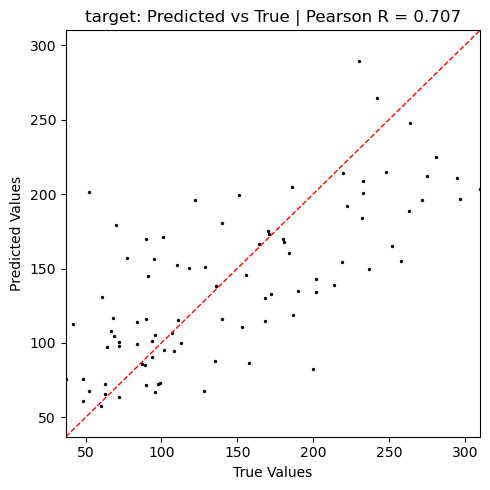

In [7]:
fig = test_report['SupportVectorMachine'].plot_pred_vs_true()

### View the MSE of the random forest model on testing data

In [8]:
print(test_report['TreeEnsemble(random_forest)'].scorer['mse'])

2796.247642764636
